## Res2net

In [3]:
import torch
import torch.nn as nn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# 网络结构
class SEModule(nn.Module):
    def __init__(self, channels, reduction = 16):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size = 1, padding = 0)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size = 1, padding = 0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        x = self.avg_pool(input)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return input * x
    
class Res2NetBottleneck(nn.Module):
    expansion = 4
    def __init__(self, inchannel, outchannel, downsample = None, stride = 1, scales = 4, groups = 1, se = True, norm_layer = True):
        super(Res2NetBottleneck, self).__init__()
        if outchannel % scales != 0:
            raise ValueError('outchannel must be divisible by scales')
        if norm_layer:
            norm_layer = nn.BatchNorm2d
        
        bottleneck_channel = groups * outchannel
        self.scales = scales
        self.stride = stride
        self.downsample = downsample
        self.conv1 = nn.Conv2d(inchannel, bottleneck_channel, kernel_size = 1, stride = stride)
        self.bn1 = norm_layer(bottleneck_channel)
        self.conv2 = nn.ModuleList([nn.Conv2d(bottleneck_channel // scales, bottleneck_channel // scales, kernel_size = 3, stride = 1, padding = 1, groups = groups) for _ in range(scales - 1)])
        self.bn2 = nn.ModuleList([norm_layer(bottleneck_channel // scales) for _ in range(scales - 1)])
        self.conv3 = nn.Conv2d(bottleneck_channel, outchannel * self.expansion, kernel_size = 1, stride = 1)
        self.bn3 = norm_layer(outchannel * self.expansion)
        self.relu = nn.ReLU(inplace = True)
        self.se = SEModule(outchannel * self.expansion) if se else None

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        xs = torch.chunk(out, self.scales, 1)
        ys = []
        for s in range(self.scales):
            if s == 0:
                ys.append(xs[s])
            elif s == 1:
                ys.append(self.relu(self.bn2[s-1](self.conv2[s-1](xs[s]))))
            else:
                ys.append(self.relu(self.bn2[s-1](self.conv2[s-1](xs[s] + ys[-1]))))
        out = torch.cat(ys, 1)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.se is not None:
            out = self.se(out)
        
        if self.downsample:
            identity = self.downsample(identity)
        out += identity
        out = self.relu(out)
        return out
    
class Res2Net(nn.Module):
    def __init__(self, layers, num_classes = 100, width = 16, scales = 4, groups = 1, zero_init_residual = True, se = True, norm_layer = True):
        super(Res2Net, self).__init__()
        if norm_layer:
            norm_layer = nn.BatchNorm2d
        outchannel = [int(width * scales * 2 ** i) for i in range(4)]
        self.inchannel = outchannel[0]

        self.conv1 = nn.Conv2d(3, outchannel[0], kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn1 = norm_layer(outchannel[0])
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        #四个残差块
        self.layer1 = self._make_layer(Res2NetBottleneck, outchannel[0], layers[0], stride=1, scales=scales, groups=groups, se=se, norm_layer=norm_layer)
        self.layer2 = self._make_layer(Res2NetBottleneck, outchannel[1], layers[1], stride=2, scales=scales, groups=groups, se=se, norm_layer=norm_layer)
        self.layer3 = self._make_layer(Res2NetBottleneck, outchannel[2], layers[2], stride=2, scales=scales, groups=groups, se=se, norm_layer=norm_layer)
        self.layer4 = self._make_layer(Res2NetBottleneck, outchannel[3], layers[3], stride=2, scales=scales, groups=groups, se=se, norm_layer=norm_layer)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(outchannel[3] * Res2NetBottleneck.expansion, num_classes)

        #初始化
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity = 'relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        #零初始化每个剩余分支中的最后一个BN，以便剩余分支从零开始，并且每个剩余块的行为类似于一个恒等式
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Res2NetBottleneck):
                    nn.init.constant_(m.bn3.weight, 0)

    def _make_layer(self, block, outchannel, blocks, stride = 1, scales = 4, groups = 1, se = True, norm_layer = True):
        if norm_layer:
            norm_layer = nn.BatchNorm2d
        downsample = None
        if stride != 1 or self.inchannel != outchannel * block.expansion:
            downsample = nn.Sequential(nn.Conv2d(self.inchannel, outchannel * block.expansion, kernel_size = 1, stride = stride),
                                       norm_layer(outchannel * block.expansion))

        layers = []
        layers.append(block(self.inchannel, outchannel, downsample, stride = stride, scales = scales, groups = groups, se = se, norm_layer = norm_layer))
        self.inchannel = outchannel * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inchannel, outchannel, scales = scales, groups = groups, se = se, norm_layer=norm_layer))
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = nn.functional.softmax(logits, dim = 1)
        return probas

net = Res2Net([3,4,6,3])
#如果有gpu就使用gpu，否则使用cpu
device = torch.device('cuda'if torch.cuda.is_available() else 'cpu')
net = net.to(device)
print(net)

#加载数据集
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4865, 0.4409], std=[0.2673, 0.2564, 0.2762])
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4865, 0.4409], std=[0.2673, 0.2564, 0.2762])
])

train_dataset = torchvision.datasets.cifar.CIFAR100(root='./data/cifar100', train=True, transform=transform_train, download=True)
test_dataset = torchvision.datasets.cifar.CIFAR100(root='./data/cifar100', train=False, transform=transform_test, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False)


#如果有gpu就使用gpu，否则使用cpu
device = torch.device('cuda'if torch.cuda.is_available() else 'cpu')
net = net.to(device)


#超参数设置
epochs = 20
BATCH_SIZE = 128
LR = 0.01

#定义损失函数和优化器
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4)
# optimizer = torch.optim.Adam(net.parameters(), lr=0.001,weight_decay=5e-4)

# 训练网络
def train(epoch, log_interval=128):
    # Set model to training model
    net.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)
        
        # Zero gradient buffers
        optimizer.zero_grad()
        # Pass data through the network
        output = net(data)
        # Calculate loss
        loss = criterion(output, target)
        # Backpropagate
        loss.backward()
        # Update weights
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.data.item()))


def validate(loss_vector, accuracy_vector):
    net.eval()
    val_loss, correct = 0, 0
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        output = net(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1]
        correct += pred.eq(target.data).cpu().sum()
    
    val_loss /= len(test_loader)
    loss_vector.append(val_loss)
    
    accuracy = 100. * correct.to(torch.float32) / len(test_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.04f}%)\n'.format(val_loss, correct, len(test_loader.dataset), accuracy))

Res2Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Res2NetBottleneck(
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): ModuleList(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (bn2): Modu

## Train for Xunjian

Train Epoch: 1 [0/50000 (0%)]	Loss: 4.604927
Train Epoch: 1 [16384/50000 (33%)]	Loss: 4.605030
Train Epoch: 1 [32768/50000 (65%)]	Loss: 4.604233
Train Epoch: 1 [49152/50000 (98%)]	Loss: 4.605561

Validation set: Average loss: 4.6023, Accuracy: 104/10000 (1.0400%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 4.605165
Train Epoch: 2 [16384/50000 (33%)]	Loss: 4.598008
Train Epoch: 2 [32768/50000 (65%)]	Loss: 4.586503
Train Epoch: 2 [49152/50000 (98%)]	Loss: 4.601414

Validation set: Average loss: 4.5866, Accuracy: 319/10000 (3.1900%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 4.599090
Train Epoch: 3 [16384/50000 (33%)]	Loss: 4.586838
Train Epoch: 3 [32768/50000 (65%)]	Loss: 4.578549
Train Epoch: 3 [49152/50000 (98%)]	Loss: 4.581113

Validation set: Average loss: 4.5830, Accuracy: 351/10000 (3.5100%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 4.587667
Train Epoch: 4 [16384/50000 (33%)]	Loss: 4.590812
Train Epoch: 4 [32768/50000 (65%)]	Loss: 4.591835
Train Epoch: 4 [49152/50000 (98%)]	Loss: 4.574572

Validatio

FileNotFoundError: [Errno 2] No such file or directory: 'figs/Res2net50_e20_loss.png'

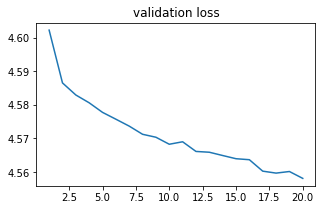

In [4]:
if __name__ == "__main__":
    lossv, accv = [], []
    for epoch in range(1, epochs + 1):
        train(epoch)
        validate(lossv, accv)

    print('Finished Training')

    # 绘制训练损失、精确度
    print("训练损失:{}\n训练精确度:{}%".format(lossv[-1], accv[-1].item()))
    plt.figure(figsize=(5,3))
    plt.plot(np.arange(1,epochs+1), lossv)
    plt.title('validation loss')
    plt.savefig('figs/Res2net50_e20_loss.png')
    
    plt.figure(figsize=(5,3))
    plt.plot(np.arange(1,epochs+1), accv)
    plt.title('validation accuracy')
    plt.savefig('figs/Res2net50_e20_accuracy.png')

训练损失:4.558101916313172
训练精确度:6.28000020980835%


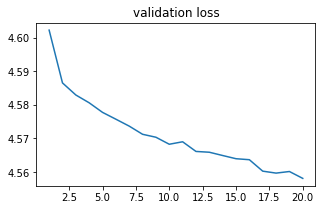

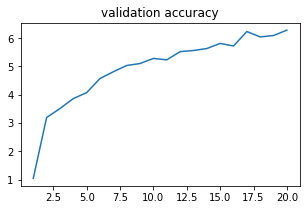

In [6]:
print("训练损失:{}\n训练精确度:{}%".format(lossv[-1], accv[-1].item()))
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')
plt.savefig('figs/Res2net50_e20_loss.png')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy')
plt.savefig('figs/Res2net50_e20_accuracy.png')